# Tracking and tracing audiovisual reuse: Introducing the Video Reuse Detector

## Tomas  Skotare [![orcid](https://orcid.org/sites/default/files/images/orcid_16x16.png)](https://orcid.org/0000-0001-8445-0559) 
Humlab, Umeå University.


## Pelle  Snickars [![orcid](https://orcid.org/sites/default/files/images/orcid_16x16.png)](https://orcid.org/0000-0001-5122-1549) 
Department of Art and Cultural Sciences, Lund University.

## Maria  Eriksson [![orcid](https://orcid.org/sites/default/files/images/orcid_16x16.png)](https://orcid.org/0000-0002-7534-4268) 
Department of Arts, Media, Philosophy, University of Basel.

The cultural reuse and reappropriation of audiovisual content has been a recurring topic of research in the humanities, not least in studies of remix cultures. An open question that remains, however, is how artificial intelligence and machine learning may help scholars study the reuse and reappropriation of audiovisual heritage. In this article, we introduce the Video Reuse Detector (VRD) – a methodological toolkit for identifying visual similarities in audiovisual archives with the help of machine learning. Designed to assist in the study of the “social life” and “cultural biographies” (<cite data-cite="1971321/6PBSUNC7"></cite>, <cite data-cite="1971321/N7PZTCJU"></cite>) of video clips, the VRD helps explore how the meaning of historic footage changes when it circulates and is recycled/cross-referenced in video productions through time. The toolkit uses machine learning techniques (specifically, convolutional neural networks), combined with tools for performing similarity searches (specifically, the Faiss library) to detect copies and near-copies in audiovisual archives. It also assembles a series of tools for trimming and preparing datasets and filtering/visualizing matching results (such as introducing similarity thresholds, filtering based on sequential matches of frames, and visually viewing the final matching results). Inspired by the “visual turn” in digital history and digital humanities research, the article will introduce the basic logic and rationale behind the VRD, exemplify how the toolkit works, and discuss how the digitization of audiovisual archives open for new ways of exploring the reuse of historic moving images. 

# Introduction

This section will provide a general introduction to the article, discuss previous research concerning cultural reuse, and provide insights into state-of-the-art uses of machine learning/CNN's in historic research, focusing on research that deals with visual content.

Chapter 3 will then guide the reader through the practical application of the toolkit in textual/narrative/descriptive form, while ***chapter 4 consists of a technical demo that showcases how the toolkit works. It is this demo that should be tested during the technical check.*** 

In chapter 5, we present a more complex demonstration of what the toolkit can do. Here, however, we work with datasets that cannot be publically released for copyright and practical reasons. Thus, the case study discussed in chapter 5 will presented in the form of images/texts. While not directly reproducible for readers, we hope that this study will illustrate the potentials and pitfalls of using CNN's to study cultural reuse.

# Video Reuse Detector

The VRD is a methodological toolkit for identifying visual similarities in audiovisual archives with the help of machine learning. It has been assembled because of the lack of open source solutions for audiovisual copy detection and is meant to help archivists and humanistic scholars study video reuse. The toolkit was originally developed within the research project European History Reloaded: Curation and Appropriation of Digital Audiovisual Heritage, funded by the JPI Cultural Heritage project, EU Horizon 2020 research and innovation program. Its main developer is Tomas Skotare, with assistance from Maria Eriksson and Pelle Snickars. The toolkit is open-source, handles all video formats supported by the FFmpeg framework, and is built to be used in Jupyter Notebooks. It can be downloaded as a docker container () and the source code is openly available on Github ().

In what follows, we introduce how the toolkit functions. We also present a demo where the VRD is applied to two videos that are openly available on [Archive.org](https://archive.org/). The first video, entitled [*The Eagle Has Landed: The Flight of Apollo 11*](https://archive.org/details/gov.archives.arc.45017), contains footage from the first moon landing in July 1969, and was released by the U.S. National Aeronautics and Space Administration (NASA) in the same year. The second video, entitled [The Moon and Us](https://archive.org/details/journey-through-the-solar-system-episode-06-the-moon-us), consists of Episode 6 from the documentary series *Journey Through the Solar System* which was also produced by NASA. First released in 1983, the series contains footage from various Apollo missions, incuding Apollo 11. Both clips are roughly 30 minutes long and are used in compliance with their respective licenses. Before uploading the videos on Github for this demo, we compressed them with HEVC in order to stay within Github's allowed file size of 100 MB/file.

In [23]:
# question to person doing technical check: any idea why this code isn't working? 
# videos won't play when notebook is rendered on journalofdigitalhistory.org

from IPython.display import Video, display

metadata={
    "jdh": {
        "module": "object",
        "object": {
            "type":"image",
            "source": [
                "The Eagle Has Landed: The Flight of Apollo 11 (1969)"
            ]
        }
    }
}


display(Video("media/demo/The Eagle Has Landed x265.mp4"), metadata=metadata)

In [12]:
# question to person doing technical check: any idea why this code isn't working? 
# videos won't play when notebook is rendered here on journalofdigitalhistory.org

from IPython.display import Video, display

metadata={
    "jdh": {
        "module": "object",
        "object": {
            "type":"image",
            "source": [
                "The Moon and Us (1983)"
            ]
        }
    }
}


display(Video("./media/demo/The Moon and Us x265.mp4"), metadata=metadata)

## Step 1. Pre-process videos

The VRD performs its similarity searches in five main steps.

To begin with, the VRD includes tools for dividing audiovisual content into still frames. Digital videos generally contain 24-30 frames per second and the VRD is instructed to extract one frame per second of video by default. It is these still images that constitute the VRD's main object of analysis.

We begin by importing a series of necessary modules.  

In [1]:
# import modules
import numpy as np
import pandas as pd
import os
import sys
sys.path.insert(0, './script/')
# we disable tensorflow warnings as they are verbose
# if things do not work, this suppression should be removed
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
from IPython.core.display import display, HTML

from vrd import neural_networks, vrd_project, faiss_helper
from vrd.neural_networks import NeuralNetworks
from vrd.sequence_finder import SequenceFinder



We also install ffmpeg since it is a prerequisite for ffmpeg-python.

In [2]:
# question to person doing technical check: 
# do you have any suggestions for how to install this in a better way?

!apt update
!apt install -y ffmpeg


Get:1 http://deb.debian.org/debian bullseye InRelease [116 kB]
Get:2 http://deb.debian.org/debian-security bullseye-security InRelease [48.4 kB]
Get:3 http://deb.debian.org/debian bullseye-updates InRelease [44.1 kB]
Get:4 http://deb.debian.org/debian bullseye/main amd64 Packages [8183 kB]
Get:5 http://deb.debian.org/debian-security bullseye-security/main amd64 Packages [229 kB]
Get:6 http://deb.debian.org/debian bullseye-updates/main amd64 Packages [14.6 kB]
Fetched 8635 kB in 3s (3304 kB/s)3m                       
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
84 packages can be upgraded. Run 'apt list --upgradable' to see them.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  alsa-topology-conf alsa-ucm-conf dbus i965-va-driver intel-media-va-driver
  libaacs0 libapparmor1 libasound2 libasound2-data libass9 libasyncns0
  libavc1394

Get:33 http://deb.debian.org/debian bullseye/main amd64 libwavpack1 amd64 5.4.0-1 [87.8 kB]
Get:34 http://deb.debian.org/debian bullseye/main amd64 libx264-160 amd64 2:0.160.3011+gitcde9a93-2.1 [539 kB]
Get:35 http://deb.debian.org/debian bullseye/main amd64 libxvidcore4 amd64 2:1.3.7-1 [242 kB]
Get:36 http://deb.debian.org/debian bullseye/main amd64 libzvbi-common all 0.2.35-18 [64.6 kB]
Get:37 http://deb.debian.org/debian bullseye/main amd64 libzvbi0 amd64 0.2.35-18 [271 kB]
Get:38 http://deb.debian.org/debian bullseye/main amd64 libavcodec58 amd64 7:4.3.5-0+deb11u1 [4960 kB]
Get:39 http://deb.debian.org/debian bullseye/main amd64 libraw1394-11 amd64 2.1.2-2 [41.1 kB]
Get:40 http://deb.debian.org/debian bullseye/main amd64 libavc1394-0 amd64 0.5.4-5 [19.9 kB]
Get:41 http://deb.debian.org/debian bullseye/main amd64 libass9 amd64 1:0.15.0-2 [100.0 kB]
Get:42 http://deb.debian.org/debian bullseye/main amd64 libudfread0 amd64 1.1.1-1 [16.4 kB]
Get:43 http://deb.debian.org/debian bullseye

Get:127 http://deb.debian.org/debian bullseye/main amd64 libxkbcommon0 amd64 1.0.3-2 [101 kB]
Get:128 http://deb.debian.org/debian bullseye/main amd64 libxrandr2 amd64 2:1.5.1-1 [37.5 kB]
Get:129 http://deb.debian.org/debian bullseye/main amd64 libsdl2-2.0-0 amd64 2.0.14+dfsg2-3+deb11u1 [506 kB]
Get:130 http://deb.debian.org/debian bullseye/main amd64 libxcb-shape0 amd64 1.14-3 [102 kB]
Get:131 http://deb.debian.org/debian bullseye/main amd64 libxv1 amd64 2:1.0.11-1 [24.6 kB]
Get:132 http://deb.debian.org/debian bullseye/main amd64 libavdevice58 amd64 7:4.3.5-0+deb11u1 [127 kB]
Get:133 http://deb.debian.org/debian bullseye/main amd64 libavresample4 amd64 7:4.3.5-0+deb11u1 [105 kB]
Get:134 http://deb.debian.org/debian bullseye/main amd64 ffmpeg amd64 7:4.3.5-0+deb11u1 [1597 kB]
Get:135 http://deb.debian.org/debian bullseye/main amd64 i965-va-driver amd64 2.4.1+dfsg1-1 [309 kB]
Get:136 http://deb.debian.org/debian bullseye/main amd64 libigdgmm11 amd64 20.4.1+ds1-1 [112 kB]
Get:137 http:/

Selecting previously unselected package libvorbis0a:amd64.
Preparing to unpack .../029-libvorbis0a_1.3.7-1_amd64.deb ...
7Progress: [ 10%] [#####.....................................................] 8Unpacking libvorbis0a:amd64 (1.3.7-1) ...
Selecting previously unselected package libvorbisenc2:amd64.
Preparing to unpack .../030-libvorbisenc2_1.3.7-1_amd64.deb ...
Unpacking libvorbisenc2:amd64 (1.3.7-1) ...
Selecting previously unselected package libvpx6:amd64.
Preparing to unpack .../031-libvpx6_1.9.0-1_amd64.deb ...
Unpacking libvpx6:amd64 (1.9.0-1) ...
Selecting previously unselected package libwavpack1:amd64.
Preparing to unpack .../032-libwavpack1_5.4.0-1_amd64.deb ...
7Progress: [ 11%] [######....................................................] 8Unpacking libwavpack1:amd64 (5.4.0-1) ...
Selecting previously unselected package libx264-160:amd64.
Preparing to unpack .../033-libx264-160_2%3a0.160.3011+gitcde9a93-2.1_amd64.deb ...
Unpacking libx264-160:amd64 (2:0.160.3011+gitcd

Selecting previously unselected package libwrap0:amd64.
Preparing to unpack .../069-libwrap0_7.6.q-31_amd64.deb ...
Unpacking libwrap0:amd64 (7.6.q-31) ...
Selecting previously unselected package libpulse0:amd64.
Preparing to unpack .../070-libpulse0_14.2-2_amd64.deb ...
Unpacking libpulse0:amd64 (14.2-2) ...
7Progress: [ 24%] [#############.............................................] 8Selecting previously unselected package libsphinxbase3:amd64.
Preparing to unpack .../071-libsphinxbase3_0.8+5prealpha+1-12_amd64.deb ...
Unpacking libsphinxbase3:amd64 (0.8+5prealpha+1-12) ...
Selecting previously unselected package libpocketsphinx3:amd64.
Preparing to unpack .../072-libpocketsphinx3_0.8+5prealpha+1-13_amd64.deb ...
Unpacking libpocketsphinx3:amd64 (0.8+5prealpha+1-13) ...
Selecting previously unselected package libpostproc55:amd64.
Preparing to unpack .../073-libpostproc55_7%3a4.3.5-0+deb11u1_amd64.deb ...
Unpacking libpostproc55:amd64 (7:4.3.5-0+deb11u1) ...
7Progress: [ 25%] [##

Unpacking libgl1-mesa-dri:amd64 (20.3.5-1) ...
7Progress: [ 37%] [#####################.....................................] 8Selecting previously unselected package libglx-mesa0:amd64.
Preparing to unpack .../109-libglx-mesa0_20.3.5-1_amd64.deb ...
Unpacking libglx-mesa0:amd64 (20.3.5-1) ...
Selecting previously unselected package libglx0:amd64.
Preparing to unpack .../110-libglx0_1.3.2-1_amd64.deb ...
Unpacking libglx0:amd64 (1.3.2-1) ...
Selecting previously unselected package libgl1:amd64.
Preparing to unpack .../111-libgl1_1.3.2-1_amd64.deb ...
Unpacking libgl1:amd64 (1.3.2-1) ...
7Progress: [ 38%] [######################....................................] 8Selecting previously unselected package libiec61883-0:amd64.
Preparing to unpack .../112-libiec61883-0_1.2.0-4_amd64.deb ...
Unpacking libiec61883-0:amd64 (1.2.0-4) ...
Selecting previously unselected package libjack-jackd2-0:amd64.
Preparing to unpack .../113-libjack-jackd2-0_1.9.17~dfsg-1_amd64.deb ...
Unpacking libjac

Setting up alsa-ucm-conf (1.2.4-2) ...
Setting up libcdio-cdda2:amd64 (10.2+2.0.0-1+b2) ...
7Progress: [ 83%] [################################################..........] 8Setting up libcdio-paranoia2:amd64 (10.2+2.0.0-1+b2) ...
Setting up libxcursor1:amd64 (1:1.2.0-2) ...
Setting up libvorbisfile3:amd64 (1.3.7-1) ...
7Progress: [ 84%] [################################################..........] 8Setting up libdc1394-25:amd64 (2.2.6-3) ...
Setting up librubberband2:amd64 (1.9.0-1) ...
Setting up libsndio7.0:amd64 (1.5.0-3) ...
7Progress: [ 85%] [#################################################.........] 8Setting up libjack-jackd2-0:amd64 (1.9.17~dfsg-1) ...
Setting up libdrm2:amd64 (2.4.104-1) ...
Setting up libflite1:amd64 (2.2-2) ...
7Progress: [ 86%] [#################################################.........] 8Setting up libva-drm2:amd64 (2.10.0-1) ...
Setting up libsord-0-0:amd64 (0.16.8-2) ...
Setting up libwayland-cursor0:amd64 (1.18.0-2~exp1.1) ...
7Progress: [ 87%] [

We start a new project and give it a name. We also inform the VRD where to locate the video files we want to work with and choose to apply with the neural network EfficientNetB4 from the Keras API. We decide to export vectors/fingerprints from a layer called Block7b_se_squeeze in EfficientNetB4.

In [3]:
# set project configuration
demo_project = vrd_project.VRDProject(
    name = 'demo_project', 
    project_base_path="./vrd_projects/",
    video_path = 'media/demo/', 
    network = neural_networks.NeuralNetworks.efficientnetb4,
    stop_at_layer='block7b_se_squeeze'
)

We extract one frame per second from each video file. These frames are saved in the project directory, under the frames subdirectory.

In [4]:
# extract frames
demo_project.initialize_frame_extractor()

  0%|          | 0/2 [00:00<?, ?it/s]

## Step 2. Produce fingerprints

Second, the VRD uses a so-called Convolutional Neural Network-–or CNN-–to extract the key visual features found in each frame. We call these extracted visual features 'fingerprints'. CNN's constitue a common technique for studying visual imagery with the help of artificial intelligence. Modelled to imitate the connectivity pattern of neurons in the visual cortex of animals, neural networks are used in areas such as facial recognition, medical imaging, and autonomous driving. We decided to work with CNN’s after doing multiple tests with more traditional tools for visual content recognition, including image hashing and video fingerprinting with help of [ORB](https://docs.opencv.org/3.4/d1/d89/tutorial_py_orb.html) (Oriented FAST and rotated BRIEF)-–a method for extracting and comparing visual features in images. CNN’s quickly outperformed the ORB technology’s ways of identifying visual similarities in video content, however, both in terms of accuracy and processing speed.

It is beyond the scope of this article to explain how CNN's work in depth (for more information on this, a good place to start is [Wikipedia](https://en.wikipedia.org/wiki/Convolutional_neural_network)), but we make a couple of remarks regarding the technology's basic technical structure. While the detailed technical workings of individual CNN's differ, neural networks are broadly designed according to multiple layers of analysis and abstraction. Each layer in a CNN will process an input and produce an output, which is passed on to the next layer. For instance, one layer in a CNN may observe how pixels are spatially arranged in an image and search for areas with a high contrast between nearby pixels (a good marker for what is visually unique in a picture), while another layer might focus on reducing what information is stored about pixel contrasts (instructing the model to “forget” all areas in a picture with a lower pixel contrast than a given value, for example). In this way, the CNN produces a successively smaller and hopefully more precise map of the analyzed image. Somewhere before the final layer of a CNN is reached, the network will produce a highly compressed interpretation of the key visual characteristics of images. It is then common for the remaining layers in a CNN to classify what appears in the image, for instance by recognizing faces and objects.

In our case, the VRD applies a CNN to process individual frames but stops when a compressed yet sufficiently complex interpretation of the key visual features of an image has been produced. Again, we call these compressed interpretations fingerprints and the VRD will use them to find patterns of similarity across videos. In more detail, the VRD will export data in the form of vectors from a given layer in a CNN. These vectors mirror the visual charachteristics found in the original frames. A vector is a mathematical quantity that discloses the magnitude (or length) and direction of a geometric object. In other words, we can say that fingerprints are mathematical abstractions that carry information about what is visually unique in each frame. What is good about fingerprints is that their detailed yet highly abstracted information can be used to recognize visual similarities even if a video has been modified or distorted. For instance, frames can be recognized as similar even if someone has adjusted their color, resolution, or composition. This is useful when studying cultural remix practices, for example. 

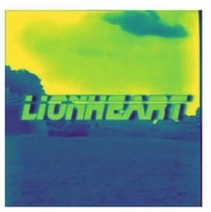

In [17]:
from IPython.display import Image, display

metadata={
    "jdh": {
        "module": "object",
        "object": {
            "type":"image",
            "source": ["Example of what a processed frame can look like when extracted from an \
intermediate layer in a CNN, before it is converted into vectors. \
In this example, the CNN ResNet50 was used."
            ]
        }
    }
}

display(Image("./media/demo/layer_example.jpg"), metadata=metadata)

When the VRD extracts its vectors/fingerprints from a given intermediate layer in a CNN––something that is otherwise done to visualize the learning process of a CNN, for example––the remaining layers of a neural net are not evaluated (more about this in the [Keras documentation](https://keras.io/getting_started/faq/#how-can-i-obtain-the-output-of-an-intermediate-layer-feature-extraction)). We partly do this to save time/computing power, and partly because we are not interested in classifying the content in images. Instead, we essentially use a CNN to compress and vectorize video frames. It is important to understand that this is not how CNN's are normally used. Therefore, we also know comparatively little about which CNN and extraction layer is best suited for the task. Commonly, the performance of CNN's are evaluated based on tests such as the [ImageNet Large Scale Visual Recognition Challenge](https://www.image-net.org/challenges/LSVRC/), where a neural network's capacity recognize objects/faces in images is compared against human beings's ways of performing the same task. Tests such as the ImageNet Challenge are not designed to evaluate a CNN's ability to compress and vectorize frames, however. When looking at previous evaluations of CNN's and deciding what neural network to use (see [Keras documentation](https://keras.io/api/applications/)), we have therefore mainly searched for CNN's that are relatively new and perform well in over-all tests. 

The current version of VRD is based on TensorFlow2, which includes the open source Keras API. [TensorFlow2](https://www.tensorflow.org/) is an open-source machine learning platform and software library for working with machine learning and artificial intelligence. It was originally developed by Google and can be used for multiple purposes, including the training and inference deep neural networks such as CNN's. The [Keras API](https://keras.io/about/) is is a deep learning API that runs on top of the TensorFlow platform. Keras functions as an interface for solving machine learning problems and provides building blocks for using machine learning methods. We use version 2.11.0 of the Keras API which makes 11 pre-trained convolutional neural networks available for use. All of these networks are open source and can easily be applied in the VRD. We mainly decided to work with pre-trained neural nets since it was unfeasible for our small research team to train a new network from scratch. Furthermore, we found that many of the neural nets in the Keras API succeeded in producing vectors that were compressed yet detailed enough to study video reuse, without needing to be re-trained our fine-tuned. Hence, we decided to work with the networks directly in their original form. Re-training the networks on relevant datasets would likely further improve the performance of the VRD, however. 

Initially, we mainly worked with the neural network [ResNet50](https://keras.io/api/applications/resnet/) (see Snickars et.al. 2023) but later switched to a network called [EfficientNetB4](https://keras.io/api/applications/efficientnet/), which is newer and performs better in accuracy tests. EfficientNet was first released by engineers at Google Research's so-called Brain Team in 2019 (<cite data-cite="1971321/K5A3FXNI"></cite>), and at the time of this article's writing, it existed in seven different versions (see [Keras documentation](https://keras.io/api/applications/efficientnet/)). We have found that version B4––which lies in the mid-range in the tradeoff between accuracy and speed among the EfficientNet versions––works well for the purpose of identifying video reuse. The current version of the VRD applies EfficientNetB4 *as is* (that is, without any re-training) and extracts its fingerprints from a layer called 'block7b_se_squeeze'. This layer is found towards the end of the network model (at the time of this article's writing, layer 463 out of 476). When deciding where to extract our fingerprint vectors, we wanted to find a layer that contained complex interpretations of the visual features in frames, yet produced vectors that were sufficiently compressed to work with large datasets. In addition, we wanted to find a layer where the neural network had not started to apply its object classification too strictly. In our tests, Block7b_se_squeeze appeared to live up to these qualifications. Importantly, however, we recommend exploring the use of other layers (and CNN's) when using the VRD, as we have not performed any comprehensive performance tests of all CNN's in the Keras API and their respective layers.

We use EfficientNetB4 to create a fingerprint for each extracted frame and use these to populate the fingerprint database. The database is saved as 'database_file' in the project directory. Note that it is important to delete any pre-existing databases and start over if another CNN is used. This is done by specifying force_recreate=True. 

In [5]:
# create fingerprints
demo_project.populate_fingerprint_database(force_recreate = False)

78864416/78864416 [==============================] - 9s 0us/step
Layer specified (block7b_se_squeeze), model index (463) will be ignored.


  0%|          | 0/3419 [00:00<?, ?it/s]

## Step 3. Calculate similarity neighbours

After saving extracted fingerprints in a database, the VRD applies its third step, where the so-called [Faiss library](https://faiss.ai/) is used to calculate the closest simiarity neighbours for each fingerprint. Faiss is an open source software library that specializes in large-scale similarity searches. First released by Facebook AI Research in 2018, it efficiently clusters dense vectors and conducts large-scale similarity searches. For instance, Faiss can be run on Graphical Processing Units (GPU’s) which provides significant advantages in terms of speed. As an open [Faiss manual](https://www.pinecone.io/learn/faiss-tutorial/) explains, Faiss will index a given set of vectors and then use another vector (called the query vector) to search for the most similar vectors within the index. Faiss allows for determining which vectors are similar by measuring the Euclidean distance between *all* given points within an index using an index called IndexFlatL2. IndexFlatL2 performs a so-called *exhaustive* search and is very accurate in its evaluation of vector similarity, but slow since it matches/compares *every* point in the index (in our case, fingerprints) against the other, one by one. To speed up this process, the Faiss index contains several methods for optimizing similarity searches, although these will always be implemented at the cost of accuracy.

For instance, it is possible to optimize the speed of a Faiss similarity search by partitioning the index (i.e. limiting the search scope to *approximate* similarity, rather than calculating an absolute similarity), or by way of so-called quantization, which involves compressing the size of vectors (more about this [here](https://www.pinecone.io/learn/faiss-tutorial/)). When the Faiss index has determined (or approximated) the similarities found within an index, it will output a so-called distance metric to each compared set of vectors. This is a value that indicates how closely related their features are, according to Faiss. A low distance metric value (or short distance) indicates high similarity and a high distance metric value (or long distance) indicates low similarity. The distance metric 0.0 represents the absolute closest similarity Faiss can ascribe to two compared vectors, and essentially corresponds to the distance that a vector would have to itself (i.e. an absolute match).

While Faiss can be used for any sort of similarity search, the VRD uses it to identify visual similarities between frame fingerprints. In particular, the VRD will apply IndexFlatL2 to perform an exhaustive search and compare all fingerprints against each other, without optimizing the similarity search. While this is costly in terms of speed/processing power, it allows the VRD to later find sequential matches in the analyzed videos--a feature that is central for how the toolkit works. It is possible for VRD users to overwrite the use of IndexFlatL2 and instead use the Faiss library's optimization methods. However, this implies that the VRD's current structure for outputting final matching results in the form of sequential matches will be lost.

To save time/memory and minimize the display of poor similarity matches, the Faiss index comes with a default setting that only shows the 100 closest neighbours for each analyzed vector. While it is generally desired to limit the amount of neighbours shown for each vector, this threshold comes with drawbacks because of how the VRD is built. More specifically, it is important to note that the threshold is applied ***before*** the VRD runs another filter that removes all matches from the same video. This can cause problems if a video contains a lot of still images or slow visual movements, since long sequeces of frames from the same video could then be given a very low distance metric. In such cases, a frame's 100 closest neighbours may be occupied by lots of frames from the same video, while other relevant matching results are "pushed" out of the top 100 list. When all matches from the same video are filtered out from the top 100 similarity neighbours, important matches could thus be lost. While it would be preferrable to filter matches from the same video *before* distance metrics are calculated and exported, the Faiss library does unfortunately not support this feature at the moment (a problem that has also been noted by [others on Github](https://github.com/facebookresearch/faiss/issues/40), for example). It is, however, possible to adjust the 100 nearest neighbour threshold to reduce the risk of filtering out interesting matching results. This is done in the VRD, as the threshold is increased from 100 to 250 by default. 

The distance metrics produced by the FAISS library constitute a core element of the VRDs evaluation of visual similarity, although it is important to note one final thing, namely that these metrics are dynamic and will change/flucuate depending on which dataset is processed. For instance, the quality of the source material and the number of images/frames in the dataset will affect how distance metrics are distributed. Likewise, the distribution of distance metrics are highly affected by which neural network and neural network layer is used. This means that there is no absolute value or threshold that indicates what distance metric value corresponds to a "correct" or "actual" instance of reuse. Instead, any use of the VRD will always involve manually exploring how each project's unique distance metric values correspond to actual visual likenesses in the source material.

We instruct Faiss to calculate the closest similarity neighbours for each fingerprint. We instruct Faiss to output the 250 closest neigbours for each fingerprint and these will be saved in the "neighbour_batch" subdirectory in the project directory. The VRD will apply Faiss IndexFlatL2 as is (i.e. perform an exhaustive search where all fingerprints in the index are compared against each other). To change this setting and make use of the Faiss library's similarity search optimization, changes have to be made to the source code. Note, however, that this will imply that the VRD's ways of finding sequential matches is lost.

We create a Faiss index of the fingerprints and save it as faiss_index in the project directory. If this has already been done once, the VRD will fetch the saved index. Note that if any changes are done to the source material (i.e. the videos, frames, or fingerprints) or the selected CNN model it is necessary to recreate the index by setting force_recreate to True.

In [6]:
# index fingerprints using Faiss
demo_project.initialize_faiss_index(force_recreate = False)

  0%|          | 0/3419 [00:00<?, ?it/s]

In [7]:
# calculate similarity neighbours
demo_project.neighbours_considered = 250
demo_project.initialize_neighbours(force_recreate = True)


  0%|          | 0/4.0 [00:00<?, ?it/s]

## Step 4. Analyze distance metric distribution

To assist in determining how distance metric values should be treated, it is possible to view a distance metric visualisation (histogram) that displays how metrics are distributed within a dataset. This may help in figuring out where to place a distance metric threshold and filter out irrelevant matching results. If the threshold is placed too low, interesting matching results may get lost. If the threshold is placed too high, there is a risk of being shown a high number of uninteresting matches.

We create a histogram to get an idea of where it might be suitable to place a distance metric threshold. When using the tool, we have found that placing the threshold around the point where the histogram indicates a sharp increase in found neighbours is a good start. 

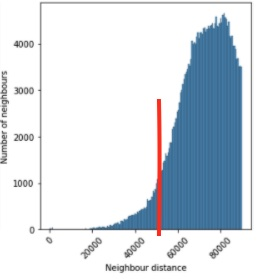

In [22]:
# question to person doing technical check: 
# the metadata/captions to images are rendered twice
# when looking at the notebook in "preview notebook"
# possible bug?

from IPython.display import Image, display

metadata={
    "jdh": {
        "module": "object",
        "object": {
            "type":"image",
            "source": ["Suggestion of where to set the threshold in the \
analysis of a distance metric histogram."
            ]
        }
    }
}

display(Image("./media/demo/distance_illustration.jpg"), metadata=metadata)

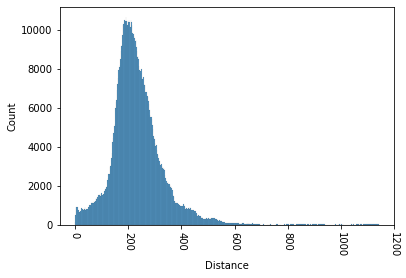

In [21]:
# get distance histogram
demo_project.neighbours.get_distance_histogram();

## Step 5.  Filter matching results

In the final step of the VRD's image processing, it is possible to narrow down the search results with the help of two major filtering features. To begin with, it is possible to implement a general distance metric threshold before the final matching results are shown. For instance, the VRD may be instructed to only show fingerprint neighbours with a distance metric below the value 30 000. If this threshold is accurate (again, manual exploration is always necessary here), it should greatly reduce the number of shown non-matching frames.

Second, the VRD includes a feature for applying what we call 'sequential filtering'. We define a sequence as an instance where two or more sequential fingerprints (i.e. frames that were extracted one after the other from the original file) from two videos have been given a distance metric below a specified value. If frame 1-6 in Video X and frame 11-16 in Video Y are each given a distance metric below the threshold 20 000, for example, this may be defined as a sequential match. Sequential filtering is used to identify instances when longer chunks of moving images have been reused and we assume that such chunks are more interesting to users than individual matching frames. Furthermore, we have found that sequential matches are generally of better quality (i.e. more indicative of actual reuse) than individual matching frames, since there is a higher likelihood that actual cases of reuse have been found when at least two frames in a row have been assigned a low distance metric. Sequential filtering is implemented by deciding the minimum sequential length (or duration in seconds/frames) of shown fingerprint neigbours. It is also possible to instruct the VRD to 'tolerate' that a given number of frames within a sequence deviates from the assigned distance metric threshold.

To summarize, the VRD thus performs its similarity search by processing audiovisual content in three main steps: as original video files are converted to still frames, as still frames are converted to fingerprints, and as fingerprints are plotted as similarity neigbours. Alternatively, one could describe this process as a matter of compressing, converting, abstracting 'raw' audiovisual content to frames, frames to vectors, and vectors to distance metrics. Furthermore, the VRD contains tools for narrowing down the search results, including features for implementing distance metric thresholds and applying sequential filtering. The final matching results are displayed in diagrams, tables, and frame previews. On the whole, these matching results are meant to function as a guide that point users towards videos that might be interesting to study manually in more detail. In other words, we strongly advise against exporting and using diagrams, tables, and thumbnail comparisons as absolute proof of video reuse and instead emphasize the need double-check the VRD's search results. The VRD should be approached as an assistance tool in navigating large video datasets. As will become evident in our explorations of reuse in the SF-archive, this is not least due to the weaknesses and pitfalls that the toolkit brings with it.

We configure some filters to narrow down the search results. We set a maximum distance metric threshold for all found sequential matches, filter out all fingerprint matches from the same video, and decide on a shortest sequence threshold (in seconds). Furthermore, we decide how many frames should be allowed to deviate from this threshold in a sequence (see 'allow skip' configuration).

In [9]:
# configure filters

finder = SequenceFinder(
    demo_project.neighbours, 
    max_distance=125)

finder.filter_matches_from_same_video()

sequences = finder.find_sequences(
    shortest_sequence=3, 
    allow_skip=1,
    
# note to self: remove combine_overlap from notebook!
    combine_overlap=True
)

3419
Maximum index found: 3418


  0%|          | 0/3419 [00:00<?, ?it/s]

Number of bytes required: 27352
Removing neighbours from same video...


  0%|          | 0/2 [00:00<?, ?it/s]

Removed 31866 entries (92.64%)!
Merged from 351 to 95 sequences


## Matching results

Final matching results are shown in the form of frame thumbnails where the longest found sequences will be show first. It is possible to limit the number of shown sequences and customize the frame size. By looking at the frame matches and distance metric values it is possible to get a sense of how previous filters can be adjusted. 

We have a look at the final matching results in the form of frame thumbnails and set the frame size and number of shown sequences.

Note that the final version of the article will include some additional visualisations and ways of filtering/sorting the matching results. 

,Start time,End time,Duration,Index,Match mean distance,# not matching
Video,,,,,,
The Moon and Us x265.mp4,00:06:56,00:07:22,26,2122,199.414444,9
The Eagle Has Landed x265.mp4,00:12:34,00:13:00,26,754,199.414444,9


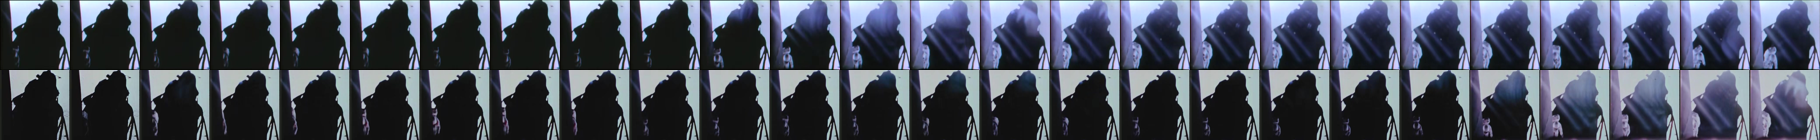

,Start time,End time,Duration,Index,Match mean distance,# not matching
Video,,,,,,
The Moon and Us x265.mp4,00:06:22,00:06:43,21,2088,193.461884,8
The Eagle Has Landed x265.mp4,00:11:16,00:11:37,21,676,193.461884,8


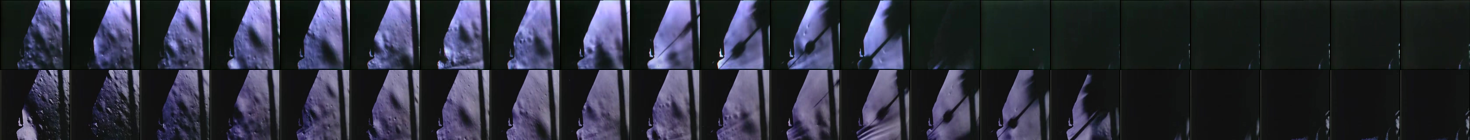

,Start time,End time,Duration,Index,Match mean distance,# not matching
Video,,,,,,
The Moon and Us x265.mp4,00:06:22,00:06:43,21,2088,234.826126,15
The Eagle Has Landed x265.mp4,00:19:02,00:19:23,21,1142,234.826126,15


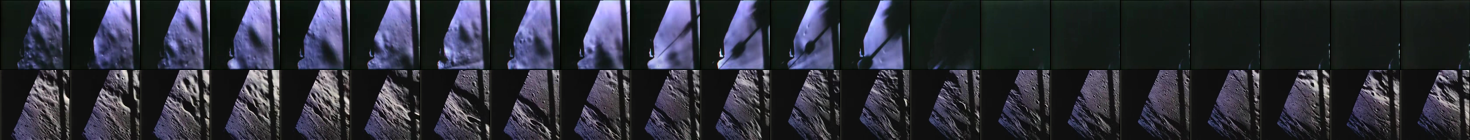

,Start time,End time,Duration,Index,Match mean distance,# not matching
Video,,,,,,
The Moon and Us x265.mp4,00:07:37,00:07:54,17,2163,181.379211,4
The Eagle Has Landed x265.mp4,00:16:45,00:17:02,17,1005,181.379211,4


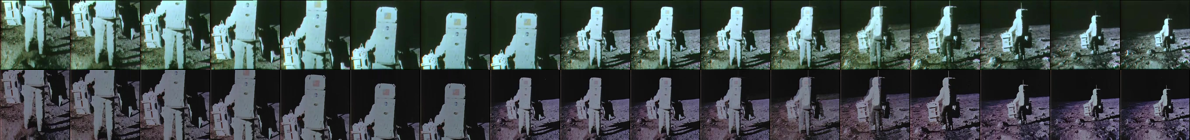

,Start time,End time,Duration,Index,Match mean distance,# not matching
Video,,,,,,
The Moon and Us x265.mp4,00:06:22,00:06:38,16,2088,218.331116,14
The Eagle Has Landed x265.mp4,00:23:10,00:23:26,16,1390,218.331116,14


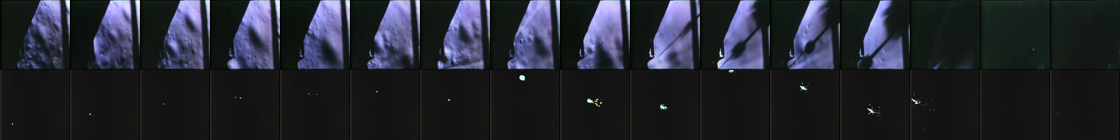

In [27]:
# question to person doing technical check: 
# does JDH have a pandas style?

# show notebook sequences
finder.show_notebook_sequence(sequences,show_limit=5, frame_resize=(70,70))

# Potentials and pitfalls

Here, we will discuss the potentials and pitfalls of using the tool.

<div class="cite2c-biblio"></div>